In [1]:
#library
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
stop = stopwords.words('english')
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from tqdm.auto import trange
from time import time
import random
import tensorflow as tf

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
corpus = pd.read_csv("/content/drive/MyDrive/clustering.csv")
corpus.drop(corpus.filter(regex="Unnamed"),axis=1, inplace=True)
corpus.head(3)

,Text
0,"Moeller's student-run newspaper, The Crusader,..."
1,"In 2008, The Crusader won First Place, the sec..."
2,The Squire is a student literary journal that ...


In [4]:
#check duplicate value
def duplicated_values_data(data):
    dup=[]
    columns=data.columns
    for i in data.columns:
        dup.append(sum(data[i].duplicated()))
    return pd.concat([pd.Series(columns),pd.Series(dup)],axis=1,keys=['Columns','Duplicate count'])
duplicated_values_data(corpus)    

,Columns,Duplicate count
0,Text,122


In [5]:
#preprocessing of data
def preprocessing(dataframe):
  dataframe['Text'] = dataframe['Text'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')      # remove url
  dataframe['Text'] = dataframe['Text'].str.replace(r'[\w\.-]+@[\w\.-]+', ' ')                                                                  # remove e-mail
  dataframe['Text'] = dataframe['Text'].str.replace(r'(?<=#)\w+', ' ')                                                                          # remove hash text
  dataframe['Text'] = dataframe['Text'].str.replace(r'(?<=@)\w+', ' ')                                                                          # remove mention
  dataframe['Text'] = dataframe['Text'].str.replace(r'[0-9]+', ' ')                                                                             # remove number                                   
  dataframe['Text'] = dataframe['Text'].str.replace(r'[^A-Za-z0-9 ]', ' ')                                                                      # remove non alphanumeric            
  dataframe['Text'] = dataframe['Text'].str.replace(r'<.*?>', ' ')                                                                              # remove tags
  dataframe['Text'] = dataframe['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))                           # remove stopwords
  dataframe['Text'] = dataframe['Text'].str.replace(r'[^\w\s]+', '')                                                                            # remove punctuation

In [6]:
preprocessing(corpus)
corpus.head(10)

,Text
0,Moeller student run newspaper The Crusader con...
1,In The Crusader First Place second highest hon...
2,The Squire student literary journal features s...
3,Paul Keels play play announcer Ohio State Univ...
4,Joe Uecker Ohio State Senator R
5,Rico Murray Undrafted free agent signee Cincin...
6,Tony Hunter professional football player Buffa...
7,Jack Norris President co founder Vegan Outreach
8,Archbishop Moeller High School established Fal...
9,Moeller High School opened doors September alo...


In [7]:
corpus  = corpus[:3000]
corpus = corpus["Text"]

In [8]:
corpus

0       Moeller student run newspaper The Crusader con...
1       In The Crusader First Place second highest hon...
2       The Squire student literary journal features s...
3       Paul Keels play play announcer Ohio State Univ...
4                         Joe Uecker Ohio State Senator R
                              ...                        
2995                            Lewis Albert Dawe Norwood
2996            Arthur Donald Andrew Dodgson Mount Cooper
2997                 Howard Norman Flaherty North Glenelg
2998                         Desmond James Moran Lockleys
2999                       Ronald Edwin Nash Henley Beach
Name: Text, Length: 3000, dtype: object

In [9]:
c = list(corpus)
corpus = list(corpus)

In [10]:
#generate label for each word 

In [11]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)
words = set(words)

In [12]:
word2int = {}
for i,word in enumerate(words):
    word2int[word] = i
data = []
for idx, sentence in enumerate(corpus):
    for word in sentence.split():
        data.append([idx, word])

In [13]:
len(word2int)

11276

In [14]:
df = pd.DataFrame(data, columns = ['pid', 'label'])
df.head(10)

,pid,label
0,0,Moeller
1,0,student
2,0,run
3,0,newspaper
4,0,The
5,0,Crusader
6,0,consistently
7,0,recognized
8,0,one
9,0,top


In [15]:
ONE_HOT_DIM_WORD = len(words)
ONE_HOT_DIM_WORD

11276

In [16]:
ONE_HOT_DIM_DOC = len(corpus)
ONE_HOT_DIM_DOC

3000

In [17]:
#One hot encoding for training

In [18]:
def to_one_hot_encoding(data_point_index, ONE_HOT_DIM):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

In [19]:
X = [] 
Y = [] 
for x, y in zip(df['pid'], df['label']):
    X.append(to_one_hot_encoding(x, ONE_HOT_DIM_DOC))
    Y.append(to_one_hot_encoding(word2int[ y ], ONE_HOT_DIM_WORD))

In [20]:
X = np.asarray(X)
y = np.asarray(Y)

In [21]:
X.shape

(34905, 3000)

In [22]:
y.shape

(34905, 11276)

In [23]:
#creating the model of Doc2Vec

In [24]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

In [25]:
batch_size = 10
for X, y in data_iter(batch_size, X, y):
#    print(X, '\n', y)
    break

In [26]:
para_size = len(corpus)
vocab_size = len(words)
num_hiddens = 3500
W1 = tf.Variable(tf.random.normal(shape=(para_size, num_hiddens), mean=0, stddev=0.01))
W2 = tf.Variable(tf.random.normal(shape=(num_hiddens, vocab_size), mean=0, stddev=0.01))
params = [W1, W2]

In [27]:
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition

In [28]:
def net(X):
    X = tf.reshape(tf.cast(X, dtype=tf.float32), (-1, para_size))
    a1 = tf.matmul(X, W1)
    a2 = tf.matmul(a1, W2)
    return softmax(a2)

In [29]:
def cross_entropy(y_hat, y):
    return -tf.math.log(tf.boolean_mask(y_hat, y))

In [30]:
def sgd(params, grads, lr, batch_size):
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

In [31]:
#training

In [32]:
num_epochs = 500
lr = 0.001
loss = cross_entropy
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, X, y):
        with tf.GradientTape() as tape:
            y_hat = net(X)
            l = loss(y_hat, y)
        grads = tape.gradient(l, params)
        sgd(params, grads, lr, batch_size)

In [33]:
vectors = W1.numpy()

In [34]:
#Calculating Cosine similarites

In [35]:
doc_vecs1 = np.array(vectors)

In [36]:
doc_vecs = doc_vecs1[:, 1:]

In [37]:
rows, cols = doc_vecs.shape
print('No. of documents: {} No. of terms: {}'.format(rows, cols))
similarity_matrix = np.zeros(shape=(rows, rows))
print(similarity_matrix.shape)

No. of documents: 3000 No. of terms: 3499
(3000, 3000)


In [61]:
for i in trange(rows, ncols=3000):
    for j in range(rows):
        similarity_matrix[i, j] = np.dot(doc_vecs[i], doc_vecs[j])

  0%|                                                                                                         …

In [65]:
print(similarity_matrix)

[[ 3.398989e-01 -3.182300e-03 -7.629700e-03 ...  4.630100e-03
   1.529000e-04 -2.749200e-03]
 [-3.182300e-03  3.583250e-01 -6.999000e-04 ... -5.044200e-03
  -5.501600e-03 -5.270400e-03]
 [-7.629700e-03 -6.999000e-04  3.535932e-01 ... -2.291400e-03
  -1.241400e-03 -4.712100e-03]
 ...
 [ 4.630100e-03 -5.044200e-03 -2.291400e-03 ...  3.640990e-01
  -2.840000e-04 -2.700900e-03]
 [ 1.529000e-04 -5.501600e-03 -1.241400e-03 ... -2.840000e-04
   3.556976e-01  1.553200e-03]
 [-2.749200e-03 -5.270400e-03 -4.712100e-03 ... -2.700900e-03
   1.553200e-03  3.315892e-01]]


In [66]:
print("Rounding off to 7 decimal places")
similarity_matrix = np.around(similarity_matrix, decimals=7)
print(similarity_matrix)

Rounding off to 7 decimal places
[[ 3.398989e-01 -3.182300e-03 -7.629700e-03 ...  4.630100e-03
   1.529000e-04 -2.749200e-03]
 [-3.182300e-03  3.583250e-01 -6.999000e-04 ... -5.044200e-03
  -5.501600e-03 -5.270400e-03]
 [-7.629700e-03 -6.999000e-04  3.535932e-01 ... -2.291400e-03
  -1.241400e-03 -4.712100e-03]
 ...
 [ 4.630100e-03 -5.044200e-03 -2.291400e-03 ...  3.640990e-01
  -2.840000e-04 -2.700900e-03]
 [ 1.529000e-04 -5.501600e-03 -1.241400e-03 ... -2.840000e-04
   3.556976e-01  1.553200e-03]
 [-2.749200e-03 -5.270400e-03 -4.712100e-03 ... -2.700900e-03
   1.553200e-03  3.315892e-01]]


In [67]:
difference_matrix = 1. - similarity_matrix
print("Difference matrix:")
print(difference_matrix)

Difference matrix:
[[0.6601011 1.0031823 1.0076297 ... 0.9953699 0.9998471 1.0027492]
 [1.0031823 0.641675  1.0006999 ... 1.0050442 1.0055016 1.0052704]
 [1.0076297 1.0006999 0.6464068 ... 1.0022914 1.0012414 1.0047121]
 ...
 [0.9953699 1.0050442 1.0022914 ... 0.635901  1.000284  1.0027009]
 [0.9998471 1.0055016 1.0012414 ... 1.000284  0.6443024 0.9984468]
 [1.0027492 1.0052704 1.0047121 ... 1.0027009 0.9984468 0.6684108]]


In [68]:
print(type(difference_matrix))

<class 'numpy.ndarray'>


In [69]:
#finding the optimal number of cluster

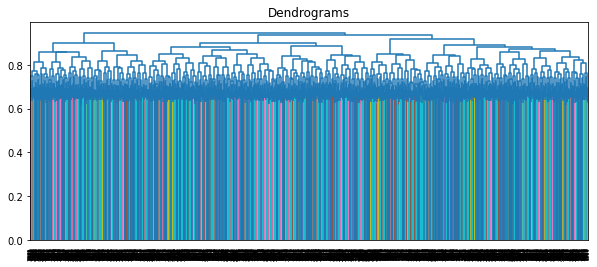

In [70]:
plt.figure(figsize = (10, 4))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(difference_matrix, method = "ward"))

In [71]:
print(dend)

{'icoord': [[5.0, 5.0, 15.0, 15.0], [25.0, 25.0, 35.0, 35.0], [10.0, 10.0, 30.0, 30.0], [55.0, 55.0, 65.0, 65.0], [45.0, 45.0, 60.0, 60.0], [85.0, 85.0, 95.0, 95.0], [75.0, 75.0, 90.0, 90.0], [52.5, 52.5, 82.5, 82.5], [20.0, 20.0, 67.5, 67.5], [105.0, 105.0, 115.0, 115.0], [135.0, 135.0, 145.0, 145.0], [125.0, 125.0, 140.0, 140.0], [110.0, 110.0, 132.5, 132.5], [165.0, 165.0, 175.0, 175.0], [155.0, 155.0, 170.0, 170.0], [185.0, 185.0, 195.0, 195.0], [205.0, 205.0, 215.0, 215.0], [190.0, 190.0, 210.0, 210.0], [162.5, 162.5, 200.0, 200.0], [121.25, 121.25, 181.25, 181.25], [43.75, 43.75, 151.25, 151.25], [225.0, 225.0, 235.0, 235.0], [255.0, 255.0, 265.0, 265.0], [245.0, 245.0, 260.0, 260.0], [230.0, 230.0, 252.5, 252.5], [275.0, 275.0, 285.0, 285.0], [295.0, 295.0, 305.0, 305.0], [280.0, 280.0, 300.0, 300.0], [325.0, 325.0, 335.0, 335.0], [345.0, 345.0, 355.0, 355.0], [330.0, 330.0, 350.0, 350.0], [315.0, 315.0, 340.0, 340.0], [290.0, 290.0, 327.5, 327.5], [241.25, 241.25, 308.75, 308.7

In [72]:
print(dend["color_list"])

['C1', 'C2', 'C0', 'C3', 'C3', 'C4', 'C4', 'C0', 'C0', 'C5', 'C6', 'C6', 'C0', 'C7', 'C7', 'C8', 'C8', 'C8', 'C0', 'C0', 'C0', 'C9', 'C1', 'C0', 'C0', 'C2', 'C3', 'C0', 'C4', 'C5', 'C0', 'C0', 'C0', 'C0', 'C6', 'C0', 'C7', 'C8', 'C0', 'C0', 'C9', 'C1', 'C1', 'C0', 'C2', 'C3', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C4', 'C5', 'C0', 'C6', 'C7', 'C0', 'C0', 'C8', 'C0', 'C9', 'C0', 'C1', 'C2', 'C2', 'C0', 'C0', 'C0', 'C0', 'C3', 'C4', 'C0', 'C5', 'C0', 'C6', 'C7', 'C0', 'C0', 'C0', 'C8', 'C8', 'C9', 'C1', 'C0', 'C0', 'C2', 'C0', 'C3', 'C3', 'C4', 'C5', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C6', 'C7', 'C0', 'C0', 'C8', 'C9', 'C9', 'C0', 'C1', 'C1', 'C2', 'C0', 'C0', 'C0', 'C0', 'C3', 'C3', 'C3', 'C4', 'C5', 'C5', 'C0', 'C0', 'C6', 'C7', 'C0', 'C8', 'C9', 'C9', 'C0', 'C0', 'C0', 'C0', 'C1', 'C2', 'C0', 'C3', 'C4', 'C0', 'C0', 'C5', 'C5', 'C6', 'C7', 'C0', 'C0', 'C0', 'C8', 'C9', 'C0', 'C0', 'C1', 'C1', 'C2', 'C0', 'C0', 'C0', 'C3', 'C3', 'C4', 'C5', 'C5', 'C0', 'C0', 'C6', 'C7', 'C0', 'C8

In [73]:
unique_color = set(dend["color_list"])
print(unique_color)

{'C0', 'C5', 'C7', 'C8', 'C6', 'C9', 'C1', 'C3', 'C2', 'C4'}


In [74]:
optimal_number_of_cluster = len(unique_color) - 1
optimal_number_of_cluster

9

In [75]:
#making the cluster

In [76]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=9, linkage='complete')
model.fit(difference_matrix)

AgglomerativeClustering(affinity='precomputed', linkage='complete',
                        n_clusters=9)

In [77]:
print(len(model.labels_))

3000


In [78]:
cluster_label = model.labels_

In [79]:
cluster_label = list(cluster_label)

In [80]:
def extractDigits(lst):
    return list(map(lambda el:[el], lst))

In [81]:
sentences = extractDigits(corpus)

In [82]:
for index, sentence in enumerate(sentences):    
     str(cluster_label[index]) + ":" + str(sentence)

In [83]:
def call_cluster(c):
    ab = []
    a=[]
    for cl_name in range(0,10):
        for i, word in enumerate(c):
            if(cluster_label[i]==cl_name):
            
                ab.append([cl_name,word])
    return ab    

In [84]:
d=call_cluster(c)
clusters_data=pd.DataFrame(d,columns=['cluster_no','sentences'])
clusters_data

,cluster_no,sentences
0,0,Moeller High School opened doors September alo...
1,0,The Moeller Crusaders long history athletic su...
2,0,Moeller High School athletic teams exception b...
3,0,Marx distinguishes simple reproduction expande...
4,0,Table All leakages injections five sector model
...,...,...
2995,8,Jean Mary McColl Weir Senior Executive Officer...
2996,8,Arthur Edward Garland Vice Consul Shipping Bri...
2997,8,Charlton Steward Gedge Vice Consul Commercial ...
2998,8,Dorothy Jane Pearey lately Personal Assistant ...


In [85]:
#saving the file

In [87]:
clusters_data.to_csv('cluster_file_ori.csv')
